# Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load Engineered Dataset

In [3]:
df = pd.read_csv("../data/urban_traffic_engineered.csv")

X = df.drop(["congestion_level", "travel_time_min"], axis=1)
y = df["congestion_level"]

# Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Preprocessing Pipeline

In [6]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Bias–Variance Demonstration (Decision Tree)

## Underfitting Tree (High Bias)

In [7]:
shallow_tree = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=2, random_state=42))
])

shallow_tree.fit(X_train, y_train)
preds = shallow_tree.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       350
         Low       1.00      1.00      1.00      1032
      Medium       1.00      1.00      1.00      1018

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



## Overfitting Tree (High Variance)

In [8]:
deep_tree = Pipeline([
    ("prep", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

deep_tree.fit(X_train, y_train)
preds = deep_tree.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       350
         Low       1.00      1.00      1.00      1032
      Medium       1.00      1.00      1.00      1018

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



# Hyperparameter Tuning (Random Forest)

## Grid Search Setup

In [9]:
rf_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}

## Run GridSearchCV

In [10]:
grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1
)

grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__max_depth': [None, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidat

## Best Model Evaluation

In [11]:
best_rf = grid.best_estimator_

preds = best_rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       350
         Low       1.00      1.00      1.00      1032
      Medium       1.00      1.00      1.00      1018

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



# XGBoost Classifier (Performance Benchmark)

## XGBoost Pipeline

In [12]:
xgb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42
    ))
])

## Train & Evaluate XGBoost

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

In [17]:
xgb_pipeline.fit(X_train, y_train_enc)

xgb_preds_enc = xgb_pipeline.predict(X_test)
xgb_preds = le.inverse_transform(xgb_preds_enc)



In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, xgb_preds))


              precision    recall  f1-score   support

        High       0.99      1.00      0.99       350
         Low       1.00      1.00      1.00      1032
      Medium       1.00      1.00      1.00      1018

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



# Learning Curves

## Learning Curve Plot

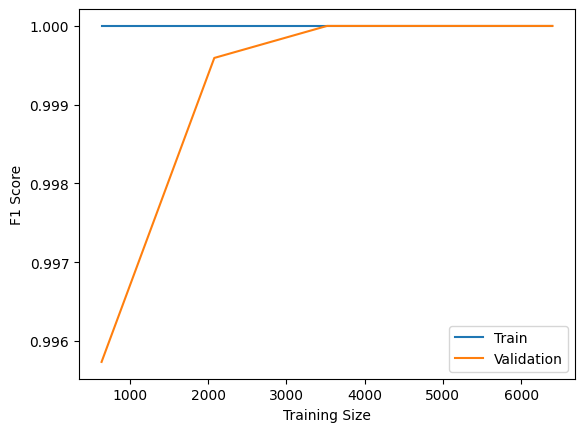

In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    best_rf,
    X_train,
    y_train,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Validation")
plt.xlabel("Training Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()